In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **70. 単語ベクトルの和による特徴量**

**データの入手・整形**

In [ ]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00359/NewsAggregatorDataset.zip
!unzip NewsAggregatorDataset.zip

import pandas as pd
from sklearn.model_selection import train_test_split

# データの読み込み
df = pd.read_csv("newsCorpora.csv", sep="\t", names=("ID","TITLE","URL","PUBLISHER","CATEGORY","STORY","HOSTNAME","TIMESTAMP"))

# "TITLE"と"CATEGORY"を抽出
data = df.loc[df["PUBLISHER"].isin(["Reuters","Huffington Post","Businessweek","Contactmusic.com","Daily Mail"]), ["TITLE","CATEGORY"]]

# データ分割　学習:検証:テスト=8:1:1
train, others = train_test_split(data, test_size=0.2, random_state=0, shuffle=True)
dev, test = train_test_split(others, test_size=0.5, random_state=0, shuffle=True)

# ファイルに保存
train.to_csv("train.txt", sep="\t", index=None)
dev.to_csv("dev.txt", sep="\t", index=None)
test.to_csv("test.txt", sep="\t", index=None)

# 事例数の確認
print(f'学習データの事例数\n{train["CATEGORY"].value_counts()}\n')
print(f'検証データの事例数\n{dev["CATEGORY"].value_counts()}\n')
print(f'テストデータの事例数\n{test["CATEGORY"].value_counts()}\n')

--2023-06-10 05:48:01--  https://archive.ics.uci.edu/ml/machine-learning-databases/00359/NewsAggregatorDataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘NewsAggregatorDataset.zip’

NewsAggregatorDatas     [  <=>               ]  27.87M  71.0MB/s    in 0.4s    

2023-06-10 05:48:02 (71.0 MB/s) - ‘NewsAggregatorDataset.zip’ saved [29224203]

Archive:  NewsAggregatorDataset.zip
  inflating: 2pageSessions.csv       
   creating: __MACOSX/
  inflating: __MACOSX/._2pageSessions.csv  
  inflating: newsCorpora.csv         
  inflating: __MACOSX/._newsCorpora.csv  
  inflating: readme.txt              
  inflating: __MACOSX/._readme.txt   
学習データの事例数
b    4481
e    4240
t    1214
m     737
Name: CATEGORY, dtype: int64

検証データの事例数
b    575
e    528
t    137
m     94
Name: CATEGORY, dtype: int64

テストデ

**単語ベクトルの読み込み**

In [ ]:
# ライブラリのインストール

! pip install gensim==4.0.1

from gensim import models

en_w2v = models.KeyedVectors.load_word2vec_format('drive/MyDrive/nlp100/GoogleNews-vectors-negative300.bin', binary=True)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.1/23.1 MB 10.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for gensim
  Running setup.py clean for gensim
Failed to build gensim
ERROR: Could not build wheels for gensim, which is required to install pyproject.toml-based projects


**特徴量生成**

In [ ]:
import string
import re
import numpy as np
import torch

def preprocessing(text):
  table = str.maketrans(string.punctuation, ' '*len(string.punctuation))
  text = text.translate(table)  # 記号をスペースに置換
  text = text.lower()  # 小文字化
  text = re.sub('[0-9]+', '', text)  # 数字除去
  text = text.split()
  return text

def vectorize(words, en_w2v):
    vectors = list()
    for word in words:
        if word in en_w2v:
          vectors.append(en_w2v[word])
        else:
          vectors.append(np.zeros(300))
    return np.array(vectors).mean(axis=0)

In [ ]:
# 前処理
train["TITLE"] = train["TITLE"].map(lambda x: preprocessing(x))
dev["TITLE"] = dev["TITLE"].map(lambda x: preprocessing(x))
test["TITLE"] = test["TITLE"].map(lambda x: preprocessing(x))

# ベクトル化
X_train = torch.tensor([vectorize(i, en_w2v) for i in train["TITLE"]], dtype=torch.float32)
X_dev = torch.tensor([vectorize(i, en_w2v) for i in dev["TITLE"]], dtype=torch.float32)
X_test = torch.tensor([vectorize(i, en_w2v) for i in test["TITLE"]], dtype=torch.float32)

# ラベル変換（str -> int）
category_dict = {'b': 0, 't': 1, 'e':2, 'm':3}
Y_train = torch.tensor(train["CATEGORY"].map(lambda x: category_dict[x]).values)
Y_dev = torch.tensor(dev["CATEGORY"].map(lambda x: category_dict[x]).values)
Y_test = torch.tensor(test["CATEGORY"].map(lambda x: category_dict[x]).values)

# 保存
torch.save(X_train, "X_train.pt")
torch.save(X_dev, "X_dev.pt")
torch.save(X_test, "X_test.pt")
torch.save(Y_train, "Y_train.pt")
torch.save(Y_dev, "Y_dev.pt")
torch.save(Y_test, "Y_test.pt")

<ipython-input-5-ddf7b2e4d49f>:7: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  X_train = torch.tensor([vectorize(i, en_w2v) for i in train["TITLE"]], dtype=torch.float32)


# **71. 単層ニューラルネットワークによる予測**

In [ ]:
from torch import nn

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc = nn.Linear(300, 4)

    def forward(self, x):
        h = self.fc(x)
        return h

In [ ]:
model = Net()
y_hat_1 = torch.softmax(model(X_train[0]), dim=-1)
Y_hat = torch.softmax(model(X_train[:4]), dim=-1)
print(y_hat_1)
print(Y_hat)

tensor([0.2486, 0.2447, 0.2456, 0.2611], grad_fn=<SoftmaxBackward0>)
tensor([[0.2486, 0.2447, 0.2456, 0.2611],
        [0.2475, 0.2505, 0.2495, 0.2526],
        [0.2515, 0.2413, 0.2532, 0.2540],
        [0.2518, 0.2419, 0.2603, 0.2460]], grad_fn=<SoftmaxBackward0>)


# **72. 損失と勾配の計算**

In [ ]:
criterion = nn.CrossEntropyLoss() # 損失関数
loss = criterion(model(X_train[0]), Y_train[0])
model.zero_grad() # 勾配初期化
loss.backward() #勾配計算
print(f"損失1：{loss}")
print(f"勾配1：\n{model.fc.weight.grad}\n")

loss = criterion(model(X_train[:4]), Y_train[:4])
model.zero_grad()
loss.backward()
print(f"損失2：{loss}")
print(f"勾配2：\n{model.fc.weight.grad}")

損失1：1.391857624053955
勾配1：
tensor([[-0.0037, -0.0417,  0.0156,  ..., -0.0592,  0.0193,  0.0337],
        [ 0.0012,  0.0136, -0.0051,  ...,  0.0193, -0.0063, -0.0110],
        [ 0.0012,  0.0136, -0.0051,  ...,  0.0193, -0.0063, -0.0110],
        [ 0.0013,  0.0145, -0.0054,  ...,  0.0206, -0.0067, -0.0117]])

損失2：1.3750096559524536
勾配2：
tensor([[ 0.0018, -0.0043, -0.0008,  ..., -0.0339,  0.0045,  0.0117],
        [ 0.0029,  0.0093, -0.0059,  ..., -0.0138, -0.0017,  0.0005],
        [-0.0077, -0.0147,  0.0128,  ...,  0.0617, -0.0009, -0.0125],
        [ 0.0030,  0.0097, -0.0060,  ..., -0.0140, -0.0019,  0.0003]])


# **73. 確率的勾配降下法による学習**

In [ ]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

train = TensorDataset(X_train, Y_train)
dev = TensorDataset(X_dev, Y_dev)
test = TensorDataset(X_test, Y_test)

batch_size = 1

train_loader = DataLoader(train, batch_size, shuffle=True)
dev_loader = DataLoader(dev, batch_size, shuffle=False)
test_loader = DataLoader(test, batch_size, shuffle=False)

In [ ]:
model = Net()

criterion = nn.CrossEntropyLoss() #損失関数

optimizer = torch.optim.SGD(model.parameters(), lr=0.1) # 最適化手法

for i in range(10):
    train_loss = []
    for batch in train_loader:
        x, t = batch
        y = model(x)
        loss = criterion(y, t)
        optimizer.zero_grad()
        loss.backward()
        train_loss.append(loss)
        optimizer.step()
    avg_loss = torch.stack(train_loss).mean()
    print(f"epoch:{i+1}  loss:{avg_loss}")

epoch:1  loss:0.525300920009613
epoch:2  loss:0.4029712975025177
epoch:3  loss:0.3746851980686188
epoch:4  loss:0.34717485308647156
epoch:5  loss:0.3286287188529968
epoch:6  loss:0.31130051612854004
epoch:7  loss:0.30434292554855347
epoch:8  loss:0.2749452292919159
epoch:9  loss:0.2610458433628082
epoch:10  loss:0.25963321328163147


# **74. 正解率の計測**

In [ ]:
def calc_accuracy(loader):
    with torch.no_grad():
        acc_list = []
        for batch in loader:
            x, t = batch
            y = model(x)

            # accuracy計算
            pred = torch.argmax(y, dim=1)
            acc = (pred == t).sum() * 1.0 / len(t)
            acc_list.append(acc)

    return torch.tensor(acc_list).mean()

In [ ]:
train_accuracy = calc_accuracy(train_loader)
print("学習：", train_accuracy.item())
test_accuracy = calc_accuracy(test_loader)
print("評価：", test_accuracy.item())

学習： 0.9297226667404175
評価： 0.8905547261238098


# **75. 損失と正解率のプロット**

In [ ]:
def calc_loss_accuracy(loader):
    with torch.no_grad():
        acc_list = []
        loss_list = []
        for batch in loader:
            x, t = batch
            y = model(x)

            # loss計算
            loss = criterion(y, t)
            loss_list.append(loss)

            # accuracy計算
            pred = torch.argmax(y, dim=1)
            acc = (pred == t).sum() * 1.0 / len(t)
            acc_list.append(acc)

    return torch.tensor(loss_list).mean(), torch.tensor(acc_list).mean()

In [ ]:
model = Net()

criterion = nn.CrossEntropyLoss() #損失関数

optimizer = torch.optim.SGD(model.parameters(), lr=0.1) # 最適化手法

log_train, log_dev = [], []
for i in range(10):
    for batch in train_loader:
        x, t = batch
        y = model(x)
        loss = criterion(y, t)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    loss_train, acc_train = calc_loss_accuracy(train_loader)
    loss_dev, acc_dev = calc_loss_accuracy(dev_loader)
    log_train.append([loss_train, acc_train])
    log_dev.append([loss_dev, acc_dev])

    # ログ表示
    print(f"epoch:{i+1}  loss_train:{loss_train:.4f}  acc_train:{acc_train:.4f}  loss_dev:{loss_dev:.4f}  acc_dev:{acc_dev:.4f}")

epoch:1  loss_train:0.3619  acc_train:0.8831  loss_dev:0.3695  acc_dev:0.8733
epoch:2  loss_train:0.3236  acc_train:0.8891  loss_dev:0.3399  acc_dev:0.8838
epoch:3  loss_train:0.3192  acc_train:0.8878  loss_dev:0.3421  acc_dev:0.8793
epoch:4  loss_train:0.2974  acc_train:0.8990  loss_dev:0.3288  acc_dev:0.8913
epoch:5  loss_train:0.3019  acc_train:0.8953  loss_dev:0.3344  acc_dev:0.8853
epoch:6  loss_train:0.2873  acc_train:0.8980  loss_dev:0.3252  acc_dev:0.8913
epoch:7  loss_train:0.2826  acc_train:0.9044  loss_dev:0.3258  acc_dev:0.8883
epoch:8  loss_train:0.2768  acc_train:0.9062  loss_dev:0.3247  acc_dev:0.8928
epoch:9  loss_train:0.2758  acc_train:0.9039  loss_dev:0.3234  acc_dev:0.8898
epoch:10  loss_train:0.2741  acc_train:0.9051  loss_dev:0.3233  acc_dev:0.8951


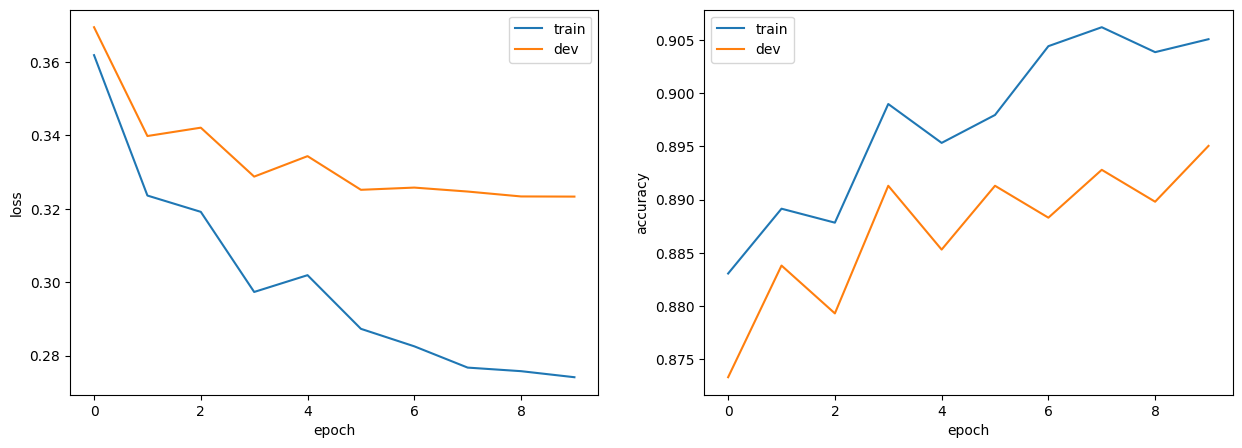

In [ ]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# 学習データ
ax[0].plot(np.array(log_train).T[0], label='train')
ax[0].plot(np.array(log_dev).T[0], label='dev')
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('loss')
ax[0].legend()

# テストデータ
ax[1].plot(np.array(log_train).T[1], label='train')
ax[1].plot(np.array(log_dev).T[1], label='dev')
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('accuracy')
ax[1].legend()
plt.show()

# **76. チェックポイント**

In [ ]:
model = Net()

criterion = nn.CrossEntropyLoss() #損失関数

optimizer = torch.optim.SGD(model.parameters(), lr=0.1) # 最適化手法

log_train, log_dev = [], []
for i in range(10):
    for batch in train_loader:
        x, t = batch
        y = model(x)
        loss = criterion(y, t)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    loss_train, acc_train = calc_loss_accuracy(train_loader)
    loss_dev, acc_dev = calc_loss_accuracy(dev_loader)
    log_train.append([loss_train, acc_train])
    log_dev.append([loss_dev, acc_dev])

    # チェックポイント保存
    torch.save({"epoch":i, "model_state_dict":model.state_dict(), "optimizer_state_dict":optimizer.state_dict()}, f"checkpoint_{i+1}.pt")

    # ログ表示
    print(f"epoch:{i+1}  loss_train:{loss_train:.4f}  acc_train:{acc_train:.4f}  loss_dev:{loss_dev:.4f}  acc_dev:{acc_dev:.4f}")

epoch:1  loss_train:0.3405  acc_train:0.8872  loss_dev:0.3929  acc_dev:0.8658
epoch:2  loss_train:0.3617  acc_train:0.8713  loss_dev:0.3977  acc_dev:0.8546
epoch:3  loss_train:0.2918  acc_train:0.8980  loss_dev:0.3468  acc_dev:0.8808
epoch:4  loss_train:0.3520  acc_train:0.8853  loss_dev:0.4143  acc_dev:0.8778
epoch:5  loss_train:0.2764  acc_train:0.9035  loss_dev:0.3596  acc_dev:0.8891
epoch:6  loss_train:0.3166  acc_train:0.8905  loss_dev:0.4291  acc_dev:0.8711
epoch:7  loss_train:0.2116  acc_train:0.9242  loss_dev:0.3506  acc_dev:0.8951
epoch:8  loss_train:0.2421  acc_train:0.9163  loss_dev:0.3802  acc_dev:0.8853
epoch:9  loss_train:0.2616  acc_train:0.9005  loss_dev:0.3959  acc_dev:0.8726
epoch:10  loss_train:0.2200  acc_train:0.9190  loss_dev:0.3826  acc_dev:0.8808


# **77. ミニバッチ化**

In [ ]:
import time

def train_model(train_dataset, dev_dataset, test_dataset, batch_size, model, criterion, optimizer, num_epochs):

    train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
    dev_loader = DataLoader(dev_dataset, batch_size, shuffle=False)

    log_train, log_dev = [], []
    for i in range(num_epochs): #計測の効率化のため、1に設定している

        #測定開始
        start = time.time()

        for batch in train_loader:
            x, t = batch
            y = model(x)
            loss = criterion(y, t)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        loss_train, acc_train = calc_loss_accuracy(train_loader)
        loss_dev, acc_dev = calc_loss_accuracy(dev_loader)
        log_train.append([loss_train, acc_train])
        log_dev.append([loss_dev, acc_dev])

        # チェックポイント保存
        torch.save({"epoch":i, "model_state_dict":model.state_dict(), "optimizer_state_dict":optimizer.state_dict()}, f"checkpoint_{i+1}.pt")

        # 測定終了
        end = time.time()

        # ログ表示
        print(f"epoch:{i+1}  loss_train:{loss_train:.4f}  acc_train:{acc_train:.4f}  loss_dev:{loss_dev:.4f}  acc_dev:{acc_dev:.4f}  {end-start:.4f}sec")

In [ ]:
model = Net()

criterion = nn.CrossEntropyLoss() #損失関数

optimizer = torch.optim.SGD(model.parameters(), lr=0.1) # 最適化手法

for batch_size in [1, 2, 4, 8, 16, 32, 64]:
    print(f"バッチサイズ:{batch_size}")
    train_model(train, dev, test, batch_size, model, criterion, optimizer, 1)

バッチサイズ:1
epoch:1  loss_train:0.3630  acc_train:0.8810  loss_dev:0.3654  acc_dev:0.8771  8.7980sec
バッチサイズ:2
epoch:1  loss_train:0.3415  acc_train:0.8876  loss_dev:0.3535  acc_dev:0.8816  5.0508sec
バッチサイズ:4
epoch:1  loss_train:0.3312  acc_train:0.8871  loss_dev:0.3462  acc_dev:0.8817  2.6477sec
バッチサイズ:8
epoch:1  loss_train:0.3272  acc_train:0.8893  loss_dev:0.3442  acc_dev:0.8845  1.4938sec
バッチサイズ:16
epoch:1  loss_train:0.3255  acc_train:0.8902  loss_dev:0.3425  acc_dev:0.8834  0.8822sec
バッチサイズ:32
epoch:1  loss_train:0.3246  acc_train:0.8910  loss_dev:0.3423  acc_dev:0.8833  0.5970sec
バッチサイズ:64
epoch:1  loss_train:0.3245  acc_train:0.8907  loss_dev:0.3418  acc_dev:0.8845  0.4355sec


# **78. GPU上での学習**

In [ ]:
from torch import nn

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc = nn.Linear(300, 4)

    def forward(self, x):
        h = self.fc(x)
        return h

In [ ]:
import time

def calc_loss_accuracy(loader, device):
    with torch.no_grad():
        acc_list = []
        loss_list = []
        for batch in loader:
            x, t = batch
            x = x.to(device)
            t = t.to(device)
            y = model(x)

            # loss計算
            loss = criterion(y, t).item()
            loss_list.append(loss)

            # accuracy計算
            pred = torch.argmax(y, dim=1)
            acc = (pred == t).sum().item() * 1.0 / len(t)
            acc_list.append(acc)

    return torch.tensor(loss_list).mean(), torch.tensor(acc_list).mean()

def train_model(train_dataset, dev_dataset, test_dataset, batch_size, model, criterion, optimizer, num_epochs, device=None):
    model.to(device)

    train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
    dev_loader = DataLoader(dev_dataset, batch_size, shuffle=False)

    log_train, log_dev = [], []
    for i in range(num_epochs): #計測の効率化のため、1に設定している

        #測定開始
        start = time.time()

        for batch in train_loader:
            x, t = batch
            x = x.to(device)
            t = t.to(device)
            y = model(x)
            loss = criterion(y, t)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        loss_train, acc_train = calc_loss_accuracy(train_loader, device)
        loss_dev, acc_dev = calc_loss_accuracy(dev_loader, device)
        log_train.append([loss_train, acc_train])
        log_dev.append([loss_dev, acc_dev])

        # チェックポイント保存
        torch.save({"epoch":i, "model_state_dict":model.state_dict(), "optimizer_state_dict":optimizer.state_dict()}, f"checkpoint_{i+1}.pt")

        # 測定終了
        end = time.time()

        # ログ表示
        print(f"epoch:{i+1}  loss_train:{loss_train:.4f}  acc_train:{acc_train:.4f}  loss_dev:{loss_dev:.4f}  acc_dev:{acc_dev:.4f}  {end-start:.4f}sec")

In [ ]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

train = TensorDataset(X_train, Y_train)
dev = TensorDataset(X_dev, Y_dev)
test = TensorDataset(X_test, Y_test)

model = Net()

criterion = nn.CrossEntropyLoss() #損失関数

optimizer = torch.optim.SGD(model.parameters(), lr=0.1) # 最適化手法

for batch_size in [1, 2, 4, 8, 16, 32, 64]:
    print(f"バッチサイズ:{batch_size}")
    train_model(train, dev, test, batch_size, model, criterion, optimizer, 1)

バッチサイズ:1
epoch:1  loss_train:0.3855  acc_train:0.8758  loss_dev:0.3945  acc_dev:0.8681  6.8143sec
バッチサイズ:2
epoch:1  loss_train:0.3410  acc_train:0.8838  loss_dev:0.3556  acc_dev:0.8793  3.8293sec
バッチサイズ:4
epoch:1  loss_train:0.3348  acc_train:0.8847  loss_dev:0.3484  acc_dev:0.8795  2.0066sec
バッチサイズ:8
epoch:1  loss_train:0.3269  acc_train:0.8887  loss_dev:0.3437  acc_dev:0.8830  1.1427sec
バッチサイズ:16
epoch:1  loss_train:0.3254  acc_train:0.8915  loss_dev:0.3435  acc_dev:0.8842  0.6879sec
バッチサイズ:32
epoch:1  loss_train:0.3243  acc_train:0.8899  loss_dev:0.3422  acc_dev:0.8826  0.5552sec
バッチサイズ:64
epoch:1  loss_train:0.3238  acc_train:0.8904  loss_dev:0.3417  acc_dev:0.8837  0.3111sec


# **79. 多層ニューラルネットワーク**

In [ ]:
from torch import nn
from torch.nn import functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(300, 3000)
        self.fc2 = nn.Linear(3000, 300)
        self.fc3 = nn.Linear(300, 4)
        self.do = nn.Dropout(0.1)


    def forward(self, x):
        h = F.relu(self.fc1(x))
        h = self.do(h)
        h = F.relu(self.fc2(h))
        h = self.fc3(h)
        return h

In [ ]:
import time

def calc_loss_accuracy(loader, device):
    with torch.no_grad():
        acc_list = []
        loss_list = []
        for batch in loader:
            x, t = batch
            x = x.to(device)
            t = t.to(device)
            y = model(x)

            # loss計算
            loss = criterion(y, t).item()
            loss_list.append(loss)

            # accuracy計算
            pred = torch.argmax(y, dim=1)
            acc = (pred == t).sum().item() * 1.0 / len(t)
            acc_list.append(acc)

    return torch.tensor(loss_list).mean(), torch.tensor(acc_list).mean()

def train_model(train_dataset, dev_dataset, test_dataset, batch_size, model, criterion, optimizer, num_epochs, device=None):
    model.to(device)

    log_train, log_dev = [], []
    for i in range(num_epochs):

        #測定開始
        start = time.time()

        for batch in train_loader:
            x, t = batch
            x = x.to(device)
            t = t.to(device)
            y = model(x)
            loss = criterion(y, t)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        loss_train, acc_train = calc_loss_accuracy(train_loader, device)
        loss_dev, acc_dev = calc_loss_accuracy(dev_loader, device)
        log_train.append([loss_train, acc_train])
        log_dev.append([loss_dev, acc_dev])

        # チェックポイント保存
        torch.save({"epoch":i, "model_state_dict":model.state_dict(), "optimizer_state_dict":optimizer.state_dict()}, f"checkpoint_{i+1}.pt")

        # 測定終了
        end = time.time()

        # ログ表示
        print(f"epoch:{i+1}  loss_train:{loss_train:.4f}  acc_train:{acc_train:.4f}  loss_dev:{loss_dev:.4f}  acc_dev:{acc_dev:.4f}  {end-start:.4f}sec")

        # 3回連続でdevのlossが下がらなかったら終わる
        if i > 2 and log_dev[i - 3][0] <= log_dev[i - 2][0] <= log_dev[i - 1][0] <= log_dev[i][0]:
            break

In [ ]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

train = TensorDataset(X_train, Y_train)
dev = TensorDataset(X_dev, Y_dev)
test = TensorDataset(X_test, Y_test)

batch_size = 64

train_loader = DataLoader(train, batch_size, shuffle=True)
dev_loader = DataLoader(dev, batch_size, shuffle=False)
test_loader = DataLoader(test, batch_size, shuffle=False)

# モデルの定義
model = Net()

criterion = nn.CrossEntropyLoss() #損失関数

optimizer = torch.optim.SGD(model.parameters(), lr=0.1) # 最適化手法

# デバイスの指定
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_model(train, dev, test, 64, model, criterion, optimizer, 30)

epoch:1  loss_train:0.6703  acc_train:0.7768  loss_dev:0.6409  acc_dev:0.7858  0.8507sec
epoch:2  loss_train:0.5404  acc_train:0.7923  loss_dev:0.5180  acc_dev:0.7989  0.8718sec
epoch:3  loss_train:0.4610  acc_train:0.8389  loss_dev:0.4489  acc_dev:0.8506  0.9373sec
epoch:4  loss_train:0.3943  acc_train:0.8757  loss_dev:0.3991  acc_dev:0.8734  0.9915sec
epoch:5  loss_train:0.3607  acc_train:0.8764  loss_dev:0.3733  acc_dev:0.8672  1.2060sec
epoch:6  loss_train:0.3382  acc_train:0.8839  loss_dev:0.3634  acc_dev:0.8800  0.9470sec
epoch:7  loss_train:0.3046  acc_train:0.8973  loss_dev:0.3404  acc_dev:0.8824  0.9657sec
epoch:8  loss_train:0.3218  acc_train:0.8852  loss_dev:0.3510  acc_dev:0.8861  1.2052sec
epoch:9  loss_train:0.2877  acc_train:0.8991  loss_dev:0.3254  acc_dev:0.8897  1.0191sec
epoch:10  loss_train:0.2861  acc_train:0.8997  loss_dev:0.3295  acc_dev:0.8911  1.0407sec
epoch:11  loss_train:0.2698  acc_train:0.9078  loss_dev:0.3200  acc_dev:0.8972  0.8798sec
epoch:12  loss_trai

In [ ]:
model.to(device)

_, train_accuracy = calc_loss_accuracy(train_loader, device)
print("学習：", train_accuracy.item())
_, test_accuracy = calc_loss_accuracy(test_loader, device)
print("評価：", test_accuracy.item())

学習： 0.9468875527381897
評価： 0.8944003582000732
